# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [20]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

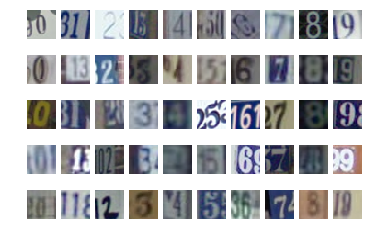

In [21]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

1
(32, 32, 3)


(-0.5, 31.5, 31.5, -0.5)

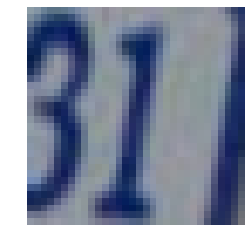

In [22]:
#binary_train_mask = (train_y == 0)
#print(binary_train_mask)
plt.subplot(1,1,1)
print(train_y[1])
img = train_X[1]
print(img.shape)
plt.imshow(img.astype(np.uint8))
plt.axis('off')

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [23]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)

binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)

binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 3*3*32]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)
#print(binary_test_X)

print(train_y[1])
print(test_y[binary_test_mask])

1
[0 0 0 9 9 0 0 0 9 9 9 9]


In [24]:
#print(binary_train_X[0])
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`

In [25]:
#print(knn_classifier.train_X.shape)

tr_X = np.array([[1, 2], [6,8], [7,1], [5,19], [5,3]]) 
te_X = np.array([[2,3], [8,1]])

n_train = tr_X.shape[0]
n_test = te_X.shape[0]

d = np.zeros((n_test,n_train),np.float32)
#print(d)
for i_test in range(te_X.shape[0]):
    for i_train in range(tr_X.shape[0]):
        d[i_test][i_train] = np.sum(np.abs(te_X[i_test] - tr_X[i_train]))
        
print(d)

# Пока изучим что к чему

# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
#print(dists[0])
#print(np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

[[ 2.  9.  7. 19.  3.]
 [ 8.  9.  1. 21.  5.]]


In [26]:
#tr_X = np.array([[1, 2], [6,8], [7,1]]) 
#te_X = np.array([[2,3], [8,1]])

#n_train = tr_X.shape[0]
#n_test = te_X.shape[0]

#d = np.zeros((n_test,n_train),np.float32)
#print(d)
#dd = np.sum(np.abs(tr_X - te_X[0]), axis=1)
#print(dd)
#print(np.sum(dd, axis=1))

#for i_test in range(n_test):
#    d[i_test] = np.sum(np.abs(tr_X - te_X[i_test]), axis=1)

#print(d)

# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
print(dists[0])
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


[174270. 199505. 188862. 289395. 266976. 295634. 131388. 184509. 169212.
 265959. 196605. 230491. 224413. 258677. 247671. 262830. 326416. 237294.
 194401. 243301. 315176. 173828. 256701. 212190. 228533. 278602. 188377.
 201297. 193816. 263092. 176022. 177912. 245887. 173540. 296105. 249531.
 277045. 180139. 301545. 223718. 250582. 181466. 138988. 212607. 224557.
 243957. 200294. 184662. 143091. 201719. 204821. 148136. 191552. 349687.
 262999. 125221. 135366. 220546. 188974. 184276. 227995. 275526. 161854.
 229868. 281405. 293070. 270636. 229897. 154712. 305461. 195368. 220091.
 210374. 136491. 155394. 327719. 295892. 182913. 249639. 218630. 286935.
 170695. 283827. 199218. 263833. 219383. 171081. 273784. 189664. 191180.
 237482. 167269. 173280. 241163. 270794. 138099. 199759. 233492. 160308.
 208149. 299253. 207483. 248010. 148360. 258735. 186333. 200462. 148770.
 225627. 230589. 179901. 213888. 197924. 182186. 144824. 203605. 201062.
 289253. 200617. 146521. 160476. 149143. 221112. 30

In [27]:
#tr_X = np.array([[1, 2], [6,8], [7,1], [5,19], [5,3]]) 
#te_X = np.array([[2,3], [8,1]])


#print()


#n_train = tr_X.shape[0]
#n_test = te_X.shape[0]

#print(n_train)
#print(n_test)
#xx = np.expand_dims(te_X, axis=1)

#print(np.sum(np.abs(tr_X - xx), axis=2))
#print(tr_X - xx)

#k = tr_X - te_X[0]
#d = np.subtract(tr_X, te_X[0])

#d = np.zeros((n_test,n_train),np.float32)
#print(k)
#print(d)
#x1 = np.arange(9.0).reshape(3,3)
#x2 = np.arange(3.0)

#print(x2[:,np.newaxis])
#dd = np.sum(np.abs(tr_X - te_X), axis=1)
#print(dd)

#for i_test in range(n_test):
#    d[i_test] = np.sum(np.abs(tr_X - te_X[i_test]), axis=1)

#print(d)

# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
#print(dists[0])
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [11]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

10.4 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.72 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.05 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
# TODO: implement predict_labels_binary in knn.py
#print(binary_test_X.shape)

#print(knn_classifier.train_X.shape)
prediction = knn_classifier.predict(binary_test_X)
#print(np.argsort(prediction[8]))
#print(prediction[8][106], prediction[7][73])

#print(binary_test_y)
#print(prediction)

# что за трениров картинки?
#plot_index = 1
#plt.subplot(1,10,plot_index)
#img = knn_classifier.train_X[106].reshape(32,32,3)
#print(img.shape)
#plt.imshow(img.astype(np.uint8))
#plt.axis('off')
#plot_index += 1
#print(knn_classifier.train_y[106])
    


True
True
True
False
False
True
True
True
False


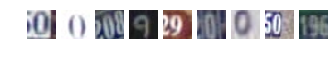

In [29]:
# что за binary_test_X ?
plot_index = 1
for i in range(9):
    plt.subplot(1,10,plot_index)
    img = binary_test_X[i].reshape(32,32,3)
    #print(img.shape)
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    plot_index += 1
    print(binary_test_y[i])

In [30]:

# TODO: implement binary_classification_metrics in metrics.py
accuracy, precision, recall, f1 = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.58, Precision: 0.60, Recall: 0.50, F1: 0.55


In [31]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.73, Precision: 0.75, Recall: 0.80, F1: 0.67


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение k! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [34]:
# Find the best k using cross-validation based on F1 score
num_folds = 6
print(binary_train_y.shape)
train_folds_X = np.split(binary_train_X, num_folds)
train_folds_y = np.split(binary_train_y, num_folds)
# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    knn_classifier_k = KNN(k=k)
    f1_by_k = 0
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    for num_f in range(num_folds):
        f_test_X = train_folds_X[num_f]
        f_test_y = train_folds_y[num_f]
        if num_f == 0:
            f_train_X = np.concatenate(train_folds_X[(num_f+1):num_folds])
            f_train_y = np.concatenate(train_folds_y[(num_f+1):num_folds])
        else:
            if (num_f+1) == num_folds:
                f_train_X = np.concatenate(train_folds_X[0:num_f])
                f_train_y = np.concatenate(train_folds_y[0:num_f])
            else:
                f_train_X = np.concatenate([
                    np.concatenate(train_folds_X[0:num_f]), 
                    np.concatenate(train_folds_X[(num_f+1):num_folds])
                ])
                f_train_y = np.concatenate([
                    np.concatenate(train_folds_y[0:num_f]), 
                    np.concatenate(train_folds_y[(num_f+1):num_folds])
                ])
        knn_classifier_k.fit(f_train_X, f_train_y)
        prediction_k = knn_classifier_k.predict(f_test_X)
        precision, recall, f1, accuracy = binary_classification_metrics(prediction_k, f_test_y)
        f1_by_k += f1
    k_to_f1[k] = f1_by_k/num_folds

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

(138,)
k = 1, f1 = 0.721440
k = 2, f1 = 0.721440
k = 3, f1 = 0.688186
k = 5, f1 = 0.749000
k = 8, f1 = 0.700733
k = 10, f1 = 0.725941
k = 15, f1 = 0.789914
k = 20, f1 = 0.844118
k = 25, f1 = 0.781625
k = 50, f1 = 0.718925


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [35]:
# TODO Set the best k to the best value found by cross-validation
best_k = 20

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 20
Accuracy: 0.80, Precision: 0.75, Recall: 0.67, F1: 1.00


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [ ]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [ ]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [18]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = np.split(binary_train_X, num_folds)
train_folds_y = np.split(binary_train_y,num_folds)

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    for num_f in range(num_folds):
        knn_classifier = KNN(k=k)
        knn_classifier.fit(train_folds_X[num_f], train_folds_y[num_f])

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

5


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [ ]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)